In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

In [33]:
df = pd.read_csv("SwimDataTop50.csv",";")

C:\Users\lukas\AppData\Local\Temp\ipykernel_22240\3450534495.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv("SwimDataTop50.csv",";")


In [34]:
# Function to parse time strings with variable formats
def parse_custom_time(time_str):
    format = len(str(time_str).split(":"))

    if format == 1:
        return pd.to_timedelta(f'00:00:{time_str}')
    elif format == 2:
        return pd.to_timedelta(f'00:{time_str}')
    elif format == 3:
        return pd.to_timedelta(time_str)

# Convert 'time' column to timedelta 
df['time'] = df['time'].apply(parse_custom_time)
df['time_seconds'] = df['time'].dt.total_seconds()
df['speed'] = df['distance'] / df['time_seconds']

# Group the data by 'surname', 'firstname', 'track length', 'technique'
grouped_data = df.groupby(['surname', 'firstname', 'track length', 'technique'])
grouped_data.size()

surname    firstname  track length  technique    
ARMSTRONG  Hunter     25            Freistil         3
                                    Rücken           2
                      50            Freistil         4
                                    Rücken           3
                                    Schmetterling    1
                                                    ..
ZHAO       Jing       50            Freestyle        1
                                    Freistil         1
                                    Lagen            2
                                    Medley           2
                                    Rücken           3
Length: 405, dtype: int64

In [35]:
def fit_rational_function(x, a, b, c):
    return 1 / (a * x + b) + c

In [70]:
def plot_rational_function(distance, speed, ax, title):
    file=open('y_points.txt','w')
    params, covariance = curve_fit(fit_rational_function, distance, speed, method="dogbox")

    x_range = np.linspace(0, 2000, 200)
    y_pred = fit_rational_function(x_range, *params)

    for number in speed:
        file.write(str(number)+",")

    ax.scatter(distance, speed, color='blue', label='Data')
    ax.plot(x_range, y_pred, color='red', label='Rational Function Fit')
    ax.set_title(title)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Speed (m/s)')

    ax.set_title(title)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Speed (m/s)')
    ax.set_ylim(1, y_pred.max()+0.1)  # Set y-axis limits
    ax.legend()
    


# Function to filter data for a specific swimmer and plot the rational function fit
def plot_rational_function_for_swimmer(df, firstname, lastname):
    filtered_df = df[(df['firstname'] == firstname) & (df['surname'] == lastname)]

    if filtered_df.empty:
        print(f"No data found for {firstname} {lastname}.")
        return

    grouped_data = filtered_df.groupby(['track length', 'technique'])

    for (track_length, technique), group in grouped_data:
        plt.figure(figsize=(15, 6))
        plot_rational_function(group['distance'], group['speed'], plt.gca(), f"Rational Function Fit for {firstname} {lastname} ({track_length}m track, {technique})")
        

        ax = plt.gca()
        
        # Set x-axis ticks and labels for specific distances
        distances_to_show = [0,50, 100, 200, 400, 800, 1500,2000]
        ax.set_xticks(distances_to_show)
        ax.set_xticklabels([str(distance) for distance in distances_to_show])
        plt.show()

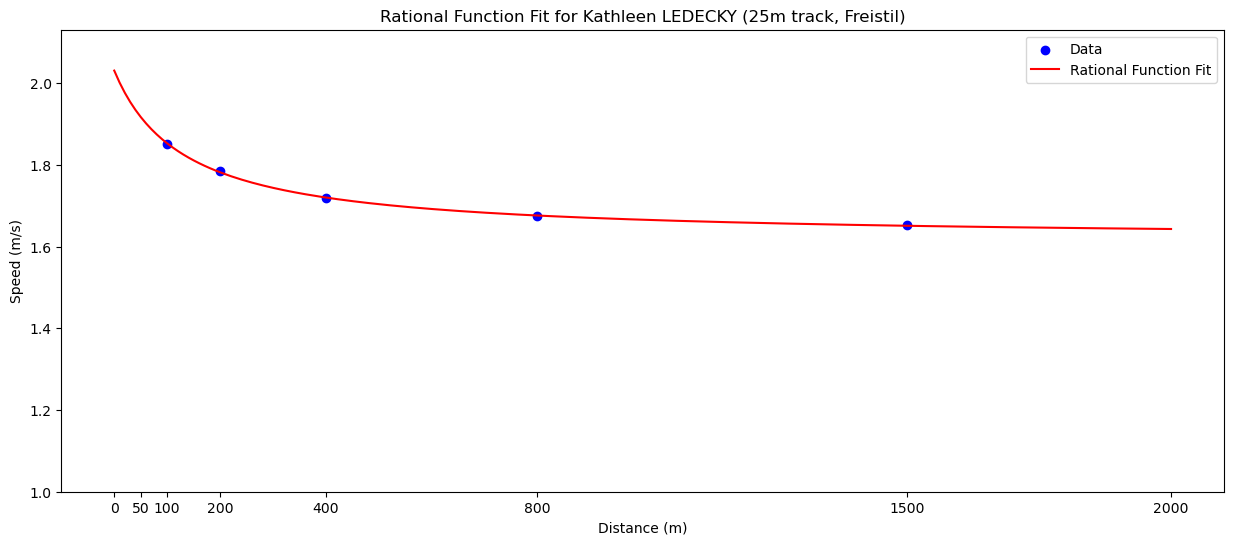

c:\Users\lukas\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


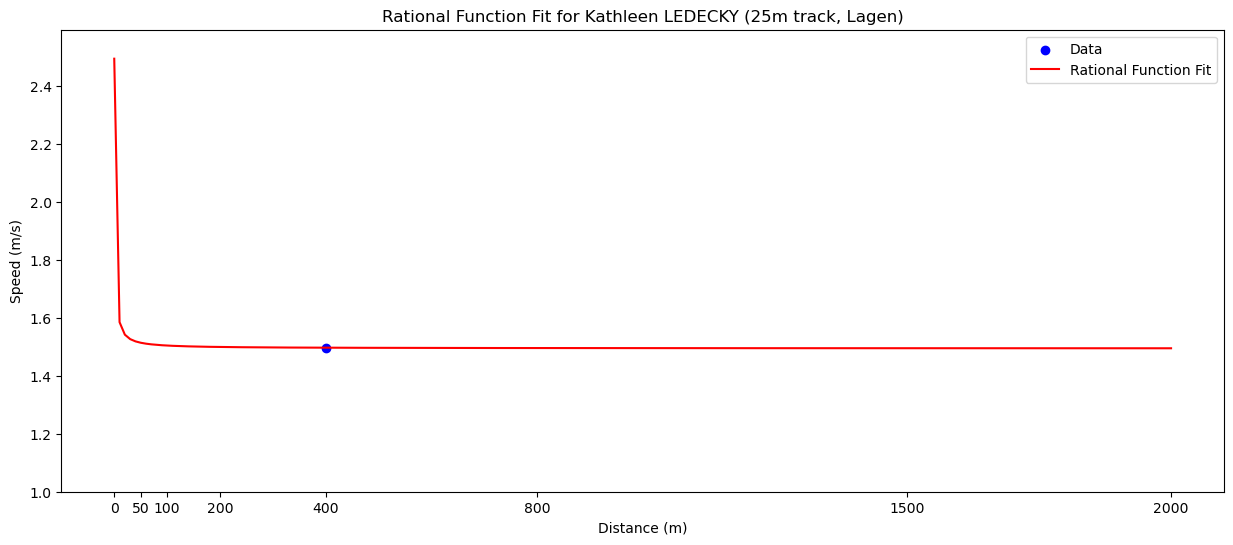

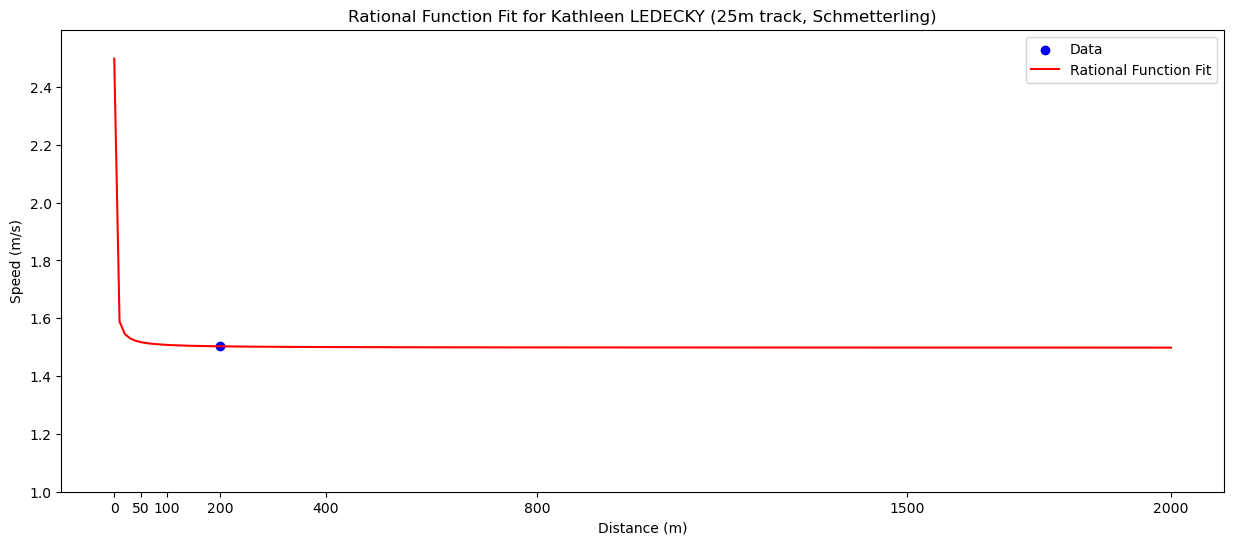

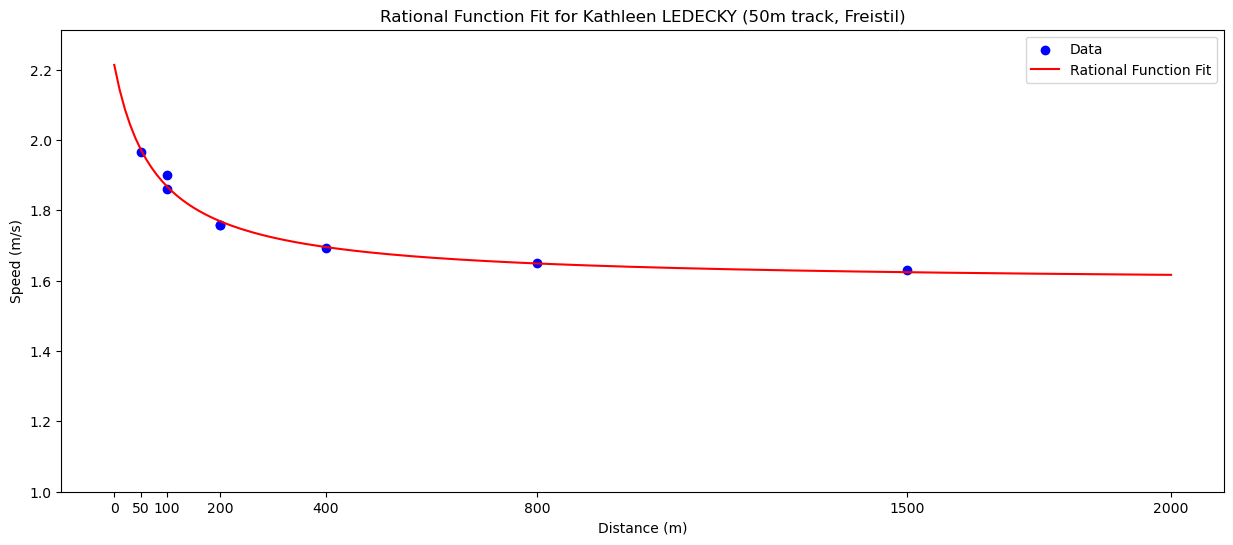

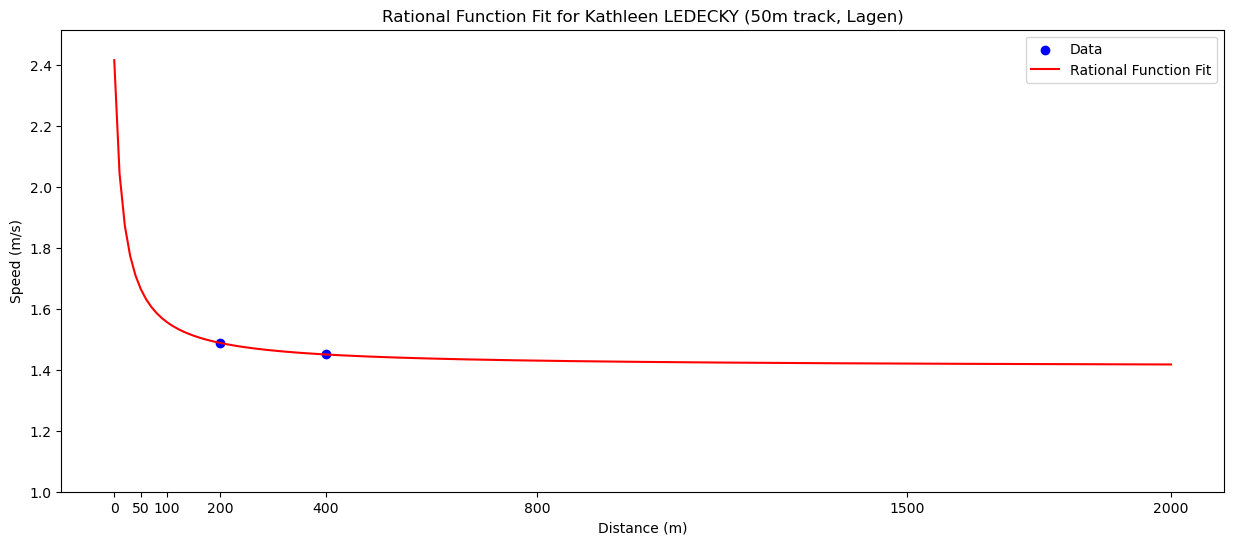

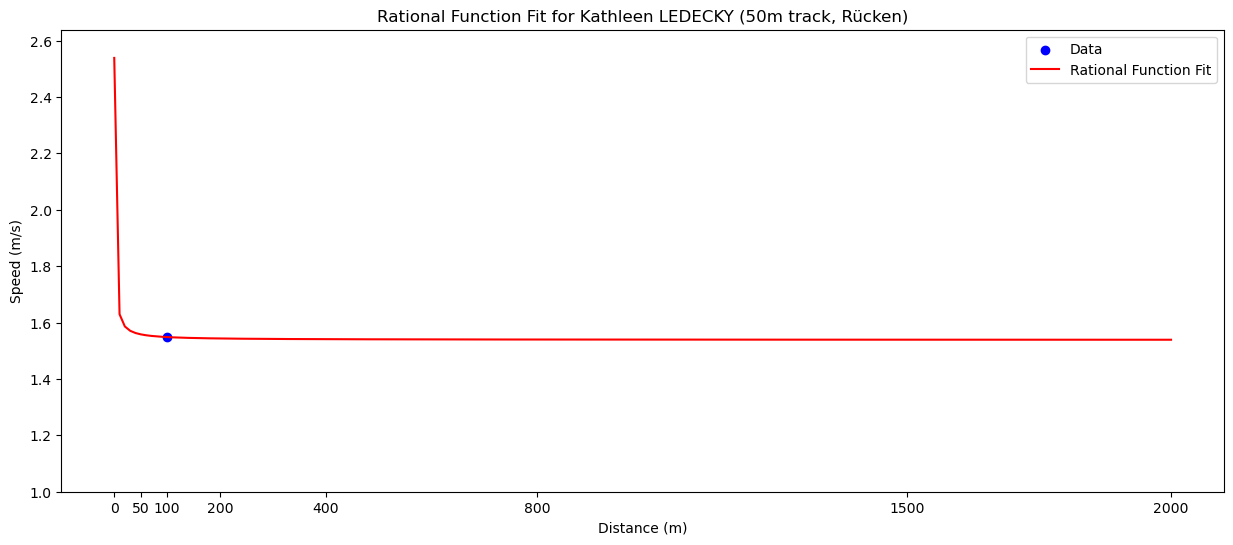

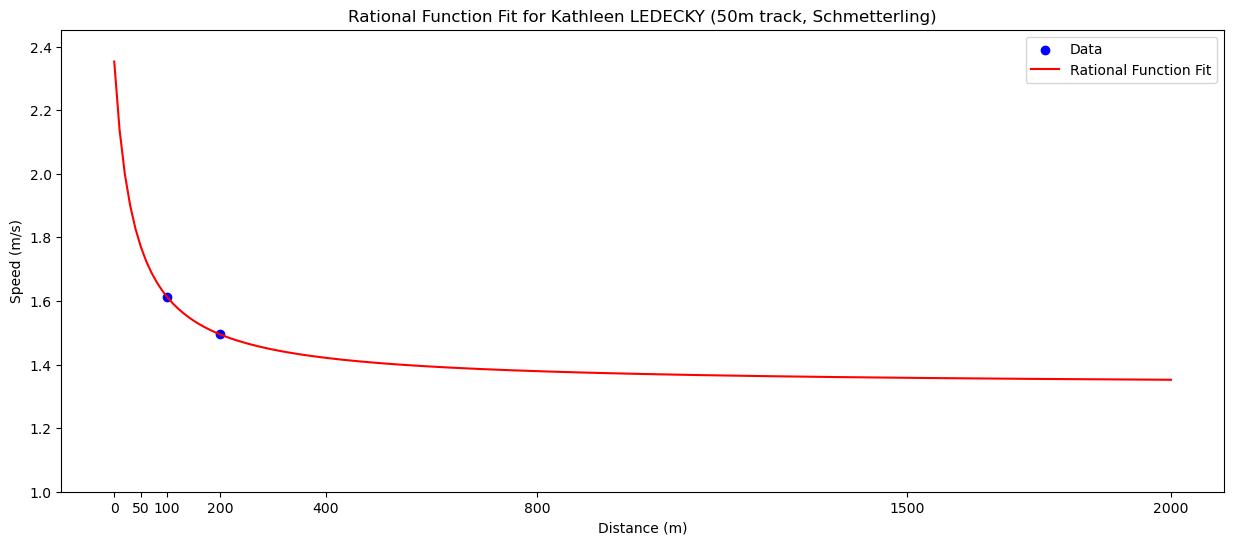

In [71]:
plot_rational_function_for_swimmer(df, firstname='Kathleen', lastname='LEDECKY')